In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import gc
import concurrent.futures
from PIL import Image, ImageChops
from tqdm import tqdm
import cv2

In [2]:
# !pip install torchvision --upgrade

In [3]:
#!pip install fastparquet
#!pip install python-snappy
#!pip install pyarrow 

In [2]:
training_labels = pd.read_csv('./train.csv')
training_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200840 entries, 0 to 200839
Data columns (total 5 columns):
image_id               200840 non-null object
grapheme_root          200840 non-null int64
vowel_diacritic        200840 non-null int64
consonant_diacritic    200840 non-null int64
grapheme               200840 non-null object
dtypes: int64(3), object(2)
memory usage: 7.7+ MB


In [3]:
training_labels.grapheme_root.nunique(), training_labels.vowel_diacritic.nunique(),\
training_labels.consonant_diacritic.nunique(), 168+11+7

(168, 11, 7, 186)

In [4]:
training_labels.grapheme_root.value_counts()

72     5736
64     5596
13     5420
107    5321
23     5149
       ... 
130     144
158     143
102     141
33      136
73      130
Name: grapheme_root, Length: 168, dtype: int64

In [5]:
training_labels.vowel_diacritic.value_counts()

0     41508
1     36886
7     28723
2     25967
4     18848
3     16152
9     16032
5      5297
6      4336
10     3563
8      3528
Name: vowel_diacritic, dtype: int64

In [6]:
training_labels.consonant_diacritic.value_counts()

0    125278
2     23465
5     21397
4     21270
1      7424
6      1387
3       619
Name: consonant_diacritic, dtype: int64

In [7]:
%%time
training_data = pd.read_parquet('./train_image_data_0.parquet')
training_data = pd.concat([training_data, 
                           pd.read_parquet('./train_image_data_1.parquet')], ignore_index=True)
training_data = pd.concat([training_data, 
                           pd.read_parquet('./train_image_data_2.parquet')], ignore_index=True)
training_data = pd.concat([training_data, 
                           pd.read_parquet('./train_image_data_3.parquet')], ignore_index=True)
gc.collect()
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200840 entries, 0 to 200839
Columns: 32333 entries, image_id to 32331
dtypes: object(1), uint8(32332)
memory usage: 6.0+ GB
Wall time: 16min 17s


In [8]:
%%time
size = 128

def save_image(row):
    test_image = np.reshape(row[1:], (137, 236))
    test_image = test_image.astype(np.int)
    test_image = Image.fromarray(test_image).convert('RGB')
    test_image = test_image.resize((size, size))
    test_image.save('./train_images/'+row[0]+'.jpg')

Wall time: 0 ns


In [10]:
for i in tqdm(range(training_data.shape[0])):
    row = training_data.iloc[i].values
    save_image(row)

100%|████████████████████████████████████████████████████████████████████████| 200840/200840 [1:45:49<00:00, 31.63it/s]


In [ ]:
import cv2
import numpy as np
im = cv2.imread('img1.jpg',0)
ret,thresh1 = cv2.threshold(im,127,255,cv2.THRESH_BINARY)
_,contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
	x,y,w,h = cv2.boundingRect(cnt)
	#bound the images
	cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),3)
i=0
for cnt in contours:
	x,y,w,h = cv2.boundingRect(cnt)
	#following if statement is to ignore the noises and save the images which are of normal size(character)
	#In order to write more general code, than specifying the dimensions as 100,
	# number of characters should be divided by word dimension
	if w>100 and h>100:
		#save individual images
		cv2.imwrite(str(i)+".jpg",thresh1[y:y+h,x:x+w])
		i=i+1
cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
cv2.imshow('BindingBox',im)

In [22]:
size = 128
HEIGHT = 137
WIDTH = 236

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=size, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [52]:
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    #Bounding box given as a 4-tuple defining the left, upper, right, and lower pixel coordinates.
    #If the image is completely empty, this method returns None.
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [74]:
import cv2

def crop_im(im, padding=0.1):
    """
    Takes cv2 image, im, and padding % as a float, padding,
    and returns cropped image.
    """
    bw = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    rows, cols = bw.shape
    non_empty_columns = np.where(bw.min(axis=0)<255)[0]
    non_empty_rows = np.where(bw.min(axis=1)<255)[0]
    cropBox = (min(non_empty_rows) * (1 - padding),
                min(max(non_empty_rows) * (1 + padding), rows),
                min(non_empty_columns) * (1 - padding),
                min(max(non_empty_columns) * (1 + padding), cols))
    cropped = im[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]

    return cropped

TypeError: Image data of dtype object cannot be converted to float

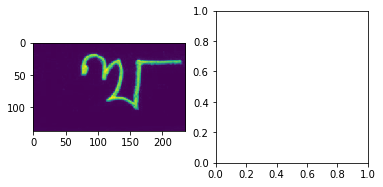

In [123]:
test_image = training_data.iloc[i+8].values[1:]
test_image = np.reshape(test_image, (137, 236))
test_image = 255 - test_image
test_image = Image.fromarray(test_image.astype(np.uint8))

plt.subplot(1,2,1)
plt.imshow(test_image)

# test_image = training_data.iloc[i+8].values[1:]
# test_image = np.reshape(test_image, (137, 236))
# test_image = 255 - test_image
# test_image = cv2.resize(test_image, (128, 128))
test_image_crop = save_image_trimmed(training_data.iloc[i+8].values)

plt.subplot(1,2,2)
plt.imshow(test_image_crop)

In [42]:
test = trim(test_image)
type(test)

NoneType

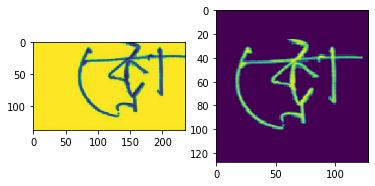

In [23]:
test_image = training_data.head(1).values[0][1:]
test_image = np.reshape(test_image, (137, 236))
test_image = test_image.astype(np.int)

plt.subplot(1,2,1)
plt.imshow(test_image)

test_image = 255 - training_data.head(1).values[0][1:]
test_image = np.reshape(test_image, (137, 236))
test_image = test_image.astype(np.uint8)

plt.subplot(1,2,2)
plt.imshow(crop_resize(test_image))

In [26]:
test = crop_resize(test_image)
test.dtype

dtype('int32')

In [28]:
cv2.imwrite('./test_image.jpg', test)

True

In [143]:
%%time
size = 128

def save_image(row):
    test_image = np.reshape(row[1:], (137, 236))
    test_image = test_image.astype(np.int)
    test_image = Image.fromarray(test_image).convert('RGB')
    test_image = test_image.resize((size, size))
    test_image.save('./train_images/'+row[0]+'.jpg')

'''with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    future_to_image = {executor.submit(save_image, row): row 
                       for row in training_data.values}
    for future in concurrent.futures.as_completed(future_to_image):
        img_prog = future_to_image[future]
        try:
            data = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (img_prog, exc))'''

Wall time: 0 ns


In [80]:
def save_image_cropped(img0, size=size, pad=16):
    img_name = img0[0:1][0]
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    img0 = 255 - np.reshape(img0[1:], (137, 236))
    img0 = img0.astype(np.uint8)  
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    img = cv2.resize(img,(size,size))
    return cv2.imwrite('./train_images/'+img_name+'.jpg', img) 

In [76]:
'''for i in tqdm(range(training_data.shape[0])):
    row = training_data.iloc[i].values
    save_image(row)'''

'for i in tqdm(range(training_data.shape[0])):\n    row = training_data.iloc[i].values\n    save_image(row)'

In [115]:
def save_image_trimmed(row):
    test_image = np.reshape(row[1:], (137, 236))
    test_image = test_image.astype(np.int)
    # test_image = np.where(test_image<20,0,test_image)
    test_image = Image.fromarray(test_image).convert('RGB')
    test_image = trim(test_image)
    test_image = test_image.resize((size, size))
    test_image.save('./train_images/'+row[0]+'.jpg')

In [144]:
for i in tqdm(range(training_data.shape[0])):
    row = training_data.iloc[i].values
    save_image(row)


  0%|▏                                                                          | 405/200840 [00:16<3:08:51, 17.69it/s]


  0%|▎                                                                          | 812/200840 [00:34<2:14:13, 24.84it/s]

KeyboardInterrupt: 

In [69]:
i

4851

In [80]:
image_data = np.asarray(test_image)
image_data_bw = image_data.max(axis=2)
non_empty_columns = np.where(image_data_bw.max(axis=0)>0)[0]
non_empty_rows = np.where(image_data_bw.max(axis=1)>0)[0]
cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))

image_data_new = image_data[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]

new_image = Image.fromarray(image_data_new)

AxisError: axis 2 is out of bounds for array of dimension 2

TypeError: Image data of dtype object cannot be converted to float

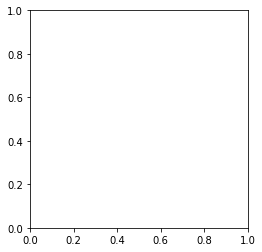

In [120]:
trim_im = save_image_trimmed(training_data.iloc[i].values)
plt.imshow(trim_im)

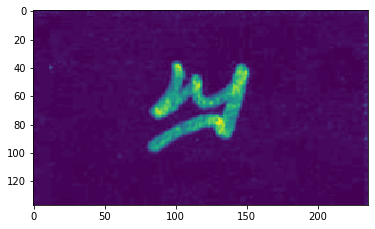

In [96]:
test_image = training_data.iloc[i].values[1:]
test_image = np.reshape(test_image, (137, 236))
test_image = 255 - test_image
test_image = Image.fromarray(test_image.astype(np.uint8))
plt.imshow(test_image)

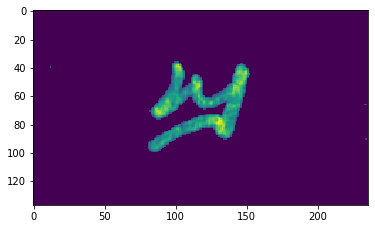

In [99]:
test_image = training_data.iloc[i].values[1:]
test_image = np.reshape(test_image, (137, 236))
test_image = 255 - test_image
test_image = np.where(test_image<20,0,test_image)
test_image = Image.fromarray(test_image.astype(np.uint8))
plt.imshow(test_image)

In [141]:
def crop(row):
    pil_image = Image.fromarray(np.reshape(row[1:], (137, 236)).astype(np.int)).convert('RGB')
    np_array = np.array(pil_image)
    blank_px = [255, 255, 255, 0]
    mask = np_array != blank_px
    coords = np.argwhere(mask)
    x0, y0, z0 = coords.min(axis=0)
    x1, y1, z1 = coords.max(axis=0) + 1
    cropped_box = np_array[x0:x1, y0:y1, z0:z1]
    return Image.fromarray(cropped_box, 'RGBA')

In [142]:
crop_im = crop(training_data.iloc[i].values)

c:\users\y2ee2\anaconda3\envs\devenv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  """


ValueError: not enough values to unpack (expected 3, got 1)